In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from pandas import DataFrame
from tqdm.autonotebook import tqdm

/tmp/ipykernel_134383/1754412377.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [9]:
data_path = '../data/raw/raw2'

## Data Preparation

Read the raw data

In [10]:
failures_path = os.path.join(data_path, 'PdM_failures.csv')
errors_path = os.path.join(data_path, 'PdM_errors.csv')
machines_path = os.path.join(data_path, 'PdM_machines.csv')
maint_path = os.path.join(data_path, 'PdM_maint.csv')
telemetry_path = os.path.join(data_path, 'PdM_telemetry.csv')

In [11]:
failures_df = pd.read_csv(failures_path)
errors_df = pd.read_csv(errors_path)
machines_df = pd.read_csv(machines_path)
maint_df = pd.read_csv(maint_path)
telemetry_df = pd.read_csv(telemetry_path)

Transform `datetime` column

In [13]:
maint_df['datetime'] = pd.to_datetime(maint_df['datetime'], format="%Y-%m-%d %H:%M:%S")
failures_df['datetime'] = pd.to_datetime(failures_df['datetime'], format="%Y-%m-%d %H:%M:%S")
errors_df['datetime'] = pd.to_datetime(errors_df['datetime'], format="%Y-%m-%d %H:%M:%S")
telemetry_df['datetime'] = pd.to_datetime(telemetry_df['datetime'], format="%Y-%m-%d %H:%M:%S")

#### Dataset transformation

Maintenance data

In [14]:
def lifespan(replacement_event_df: DataFrame)->DataFrame:
    
    '''
    Receives a dataframe with timestamp and columns that signify when a component is replaced, with 1.
    Returns a dataframe with the days since the last replacement for the component
    '''
    
    comp_rep=replacement_event_df.copy()
    points = comp_rep['machineID'].unique()
    final=pd.DataFrame()
    
    for i in tqdm(points, desc='Machine'):
        df = comp_rep[(comp_rep['machineID']==i)][['datetime','machineID','comp_comp1', 'comp_comp2', 'comp_comp3', 'comp_comp4']]
        for comp in ['comp_comp1', 'comp_comp2', 'comp_comp3', 'comp_comp4']:
            
            # keep the last part of component name
            life=comp[5:]
            
            #apply function in each row of df[life] column where if row[comp]==1 then value=0.041667 else 0
            df[life] = df.apply(lambda row: 0 if row[comp]==1 else 0.041667, axis=1) # 0.041667 days is 1 hour difference
            df[life] = df[life].cumsum()
            
        final=pd.concat([final,df],axis=0)
        final=final[['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']]
    return final.copy()

In [15]:
maint_transf_df = pd.get_dummies(maint_df, columns=['comp'])
maint_transf_df = telemetry_df.merge(maint_transf_df, on=['datetime', 'machineID'], how='left')
maint_transf_df= maint_transf_df[['datetime', 'machineID', 'comp_comp1', 'comp_comp2', 'comp_comp3', 'comp_comp4']]
maint_transf_df = maint_transf_df.fillna(0)

In [19]:
maintenance_df = lifespan(maint_transf_df)

Machine:   0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
maintenance_df.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,0.041667,0.041667,0.041667,0.041667
1,2015-01-01 07:00:00,1,0.083334,0.083334,0.083334,0.083334
2,2015-01-01 08:00:00,1,0.125001,0.125001,0.125001,0.125001
3,2015-01-01 09:00:00,1,0.166668,0.166668,0.166668,0.166668
4,2015-01-01 10:00:00,1,0.208335,0.208335,0.208335,0.208335


#### Merging the rest of the datasets

In [21]:
#fget dummies for errorID
error_count = pd.get_dummies(errors_df, columns=['errorID'])
error_count.rename(columns={'errorID_error5':'error5count'}, inplace=True)
error_count.rename(columns={'errorID_error4':'error4count'}, inplace=True)
error_count.rename(columns={'errorID_error3':'error3count'}, inplace=True)
error_count.rename(columns={'errorID_error2':'error2count'}, inplace=True)
error_count.rename(columns={'errorID_error1':'error1count'}, inplace=True)

features = telemetry_df.merge(error_count, on=['datetime', 'machineID'], how='left')

# Propagate the error information per error type
features[['error1count','error2count','error3count','error4count','error5count']] = features[['error1count','error2count','error3count','error4count','error5count']].fillna(method='ffill')
# Fill the iinital error count with 0
features = features.fillna(0)

# Add the machine metadata information
features = features.merge(machines_df, on=['machineID'], how='left')

features = features.merge(maint_transf_df, on=['datetime', 'machineID'], how='left')

Merge the failures dataset

In [22]:
fails = pd.get_dummies(failures_df,columns=['failure'])
fails.rename(columns={'failure_comp1':'comp1'}, inplace=True)
fails.rename(columns={'failure_comp2':'comp2'}, inplace=True)
fails.rename(columns={'failure_comp3':'comp3'}, inplace=True)
fails.rename(columns={'failure_comp4':'comp4'}, inplace=True)

In [23]:
def lifespan_fails(comp_rep0):
    comp_rep=comp_rep0.copy()
    points = comp_rep['machineID'].unique()
    final=pd.DataFrame()

    for i in points:
        df = comp_rep[(comp_rep['machineID']==i)][['datetime','machineID','comp1','comp2','comp3','comp4']]
        for comp in ['comp1','comp2','comp3','comp4']:
            life=comp+'_life'
#             prob=comp+'_prob'
#             probkm=comp+'_probkm'
            df[life] = df.apply(lambda row: row['datetime'] if row[comp]==0 else np.nan, axis=1)
            df[df[life].isna()==False].index
            df[life].fillna(method='backfill', inplace=True)
            df[life] = pd.to_datetime(df[life]) - df['datetime']
            df[life] = df[life].apply(lambda row: row.total_seconds()/86400)
#             df[prob] = df[life]/(df[life]+df[comp])
#             df[prob].fillna(1, inplace=True)
#             df[probkm] = 1-1/(df[life]+df[comp])
            #back fill with pad
#             df[probkm]=df[probkm].replace(-np.inf, np.nan)
            
        final=pd.concat([final,df],axis=0)
    return final.copy()

In [24]:
fails_ = telemetry_df.merge(fails, on=['datetime', 'machineID'], how='left')

In [25]:
fails_ = fails_.fillna(method='bfill', limit=24) # fill backward up to 24h if all data, otherwise it must be  7

In [26]:
fails_transf = lifespan_fails(fails_)

In [27]:
# For the individual components that fail , the columns with 0 or 1, after the merge and backfill
fails_transf = fails_transf.fillna(0)

In [28]:
labeled_features = features.merge(fails_transf, on=['datetime', 'machineID'], how='left')
# labeled_features = labeled_features.fillna(method='bfill', limit=24) # fill backward up to 24h if all data, otherwise it must be  7

In [31]:
# # convert "failure" target variables into multiple binary targets 
# # i.e. one per component indicating failure/no failure
# labeled_features['comp1_fail'] = (labeled_features['failure'] == 'comp1').astype(int)
# labeled_features['comp2_fail'] = (labeled_features['failure'] == 'comp2').astype(int)
# labeled_features['comp3_fail'] = (labeled_features['failure'] == 'comp3').astype(int)
# labeled_features['comp4_fail'] = (labeled_features['failure'] == 'comp4').astype(int)

## Exploratory data analysis

Machine age - machine age by model

In [29]:
def plot_boxh_groupby(df, feature_name, by):
    """
    Box plot with groupby
    
    df: DataFrame
    feature_name: Name of the feature to be plotted
    by: Name of the feature based on which groups are created
    """
    df.boxplot(column=feature_name, by=by, vert=False, 
                              figsize=(10, 6))
    plt.title(f'Distribution of {feature_name} by {by}')
    plt.show()
    
    
def plot_histogram(df, attribute, title_name, bins, figsize=(9,3), alpha=1, label=None):
    df[attribute].plot(kind='hist', 
                              bins=bins, 
                              figsize=figsize,
                              alpha=alpha,
                              label=label,
                              title=f'{title_name.title()} distribution')
    
def plot_bar_sortvals(df, attribute, title, figsize=(5,5)):
    df[attribute].value_counts(
                normalize=False, dropna=False).sort_values().plot(
                kind='bar', figsize=figsize, grid=True,
                title=title)

    
def plot_scatter(df, x_axis_attr, y_axis_attr, figsize=(5,5), title=None, legend=None):
    df.plot.scatter(x_axis_attr, y_axis_attr, 
                    figsize=figsize, title=title, 
                    legend=legend)


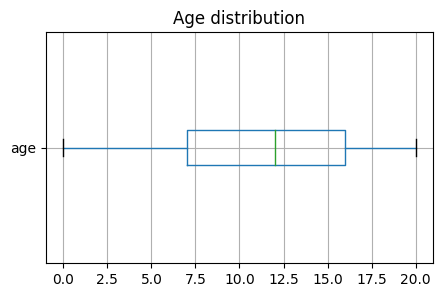

In [31]:
labeled_features.boxplot(column='age', vert=False, figsize=(5,3))
plt.title('Age distribution')
plt.show()

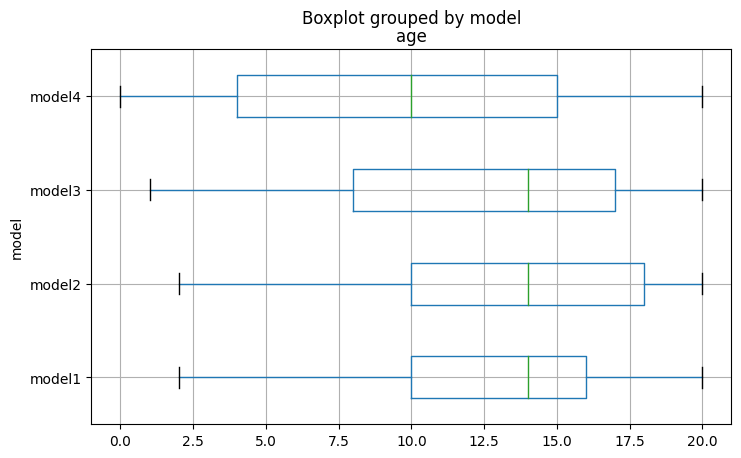

In [32]:
labeled_features.boxplot(column='age', by='model', vert=False, figsize=(8,5))
plt.show()

```
We can see that `model 4` has the lowest median age
```

Failure per component

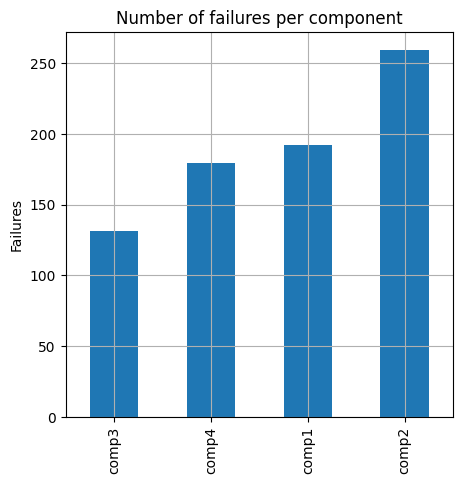

In [33]:
plot_bar_sortvals(failures_df, 'failure', 'Number of failures per component')
plt.ylabel('Failures')
plt.show()

Telemetry data

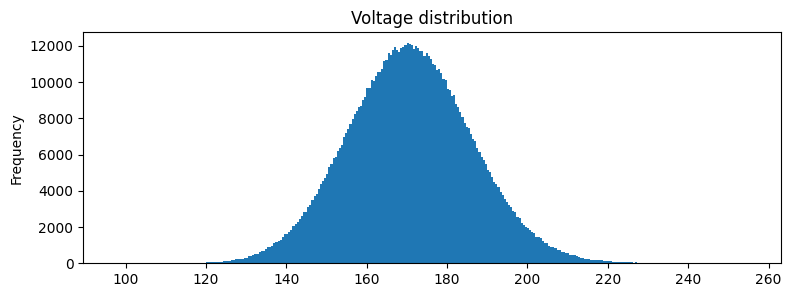

In [34]:
plot_histogram(labeled_features, 'volt', 'Voltage', bins=300)
plt.show()

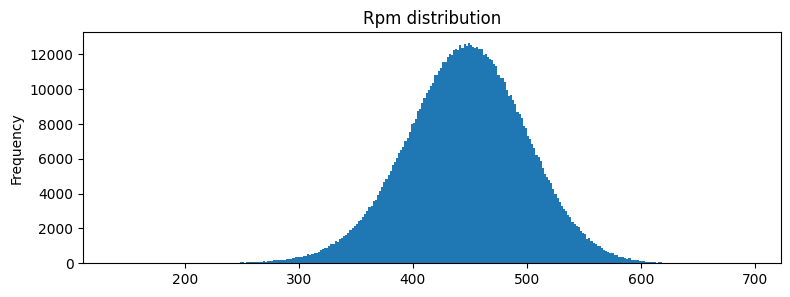

In [35]:
plot_histogram(labeled_features, 'rotate', 'RPM', bins=300)
plt.show()

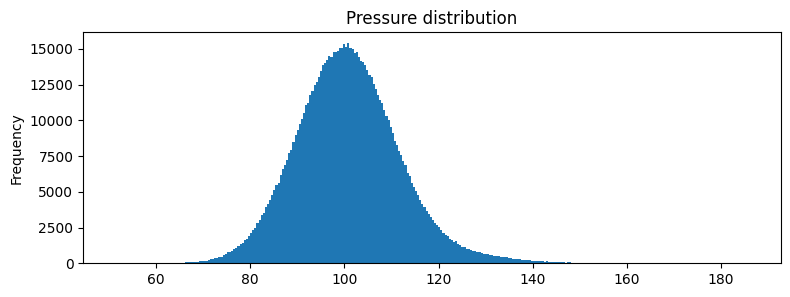

In [36]:
plot_histogram(labeled_features, 'pressure', 'Pressure', bins=300)
plt.show()

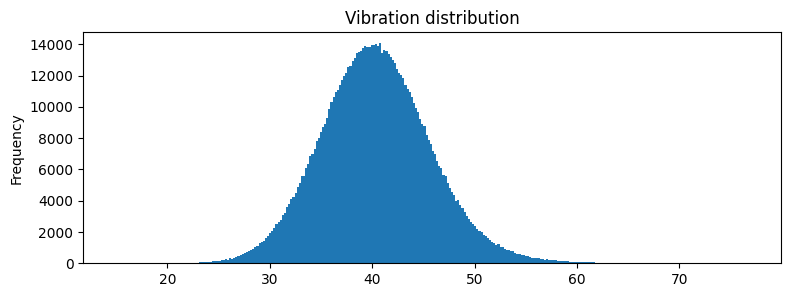

In [37]:
plot_histogram(labeled_features, 'vibration', 'Vibration', bins=300)
plt.show()

```
All the telemetry data, taking into consideration all machines, look to be normally distributed. The odd one being rotation, which looks a skewed on the left.
```

/tmp/ipykernel_134383/2248925645.py:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for model in labeled_features.groupby(['model']):


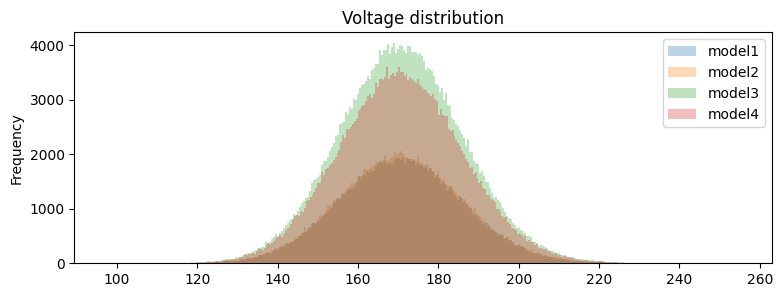

In [38]:
for model in labeled_features.groupby(['model']):
    plot_histogram(model[1], 'volt', 'Voltage',bins=300, alpha=0.3, label=model[0])

plt.legend()
plt.show()

/tmp/ipykernel_134383/3419533908.py:1: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for model in labeled_features.groupby(['model']):


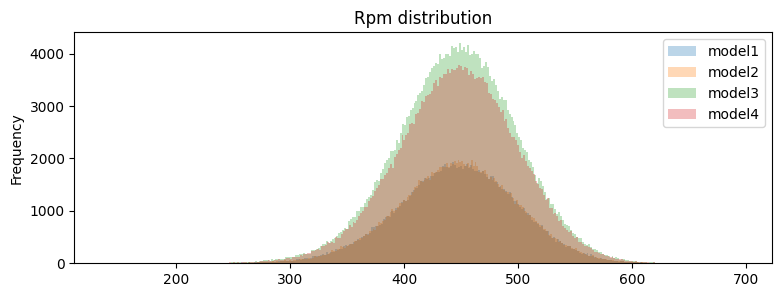

In [39]:
for model in labeled_features.groupby(['model']):
    plot_histogram(model[1], 'rotate', 'RPM',bins=300, alpha=0.3, label=model[0])

plt.legend()
plt.show()

#### Create a temporary dataframe, which is the `labeled_features` dataframe used in training, but augmented with time features:

Errors

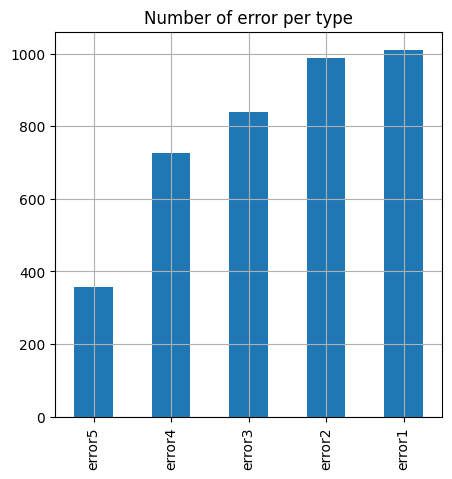

In [40]:
plot_bar_sortvals(errors_df, 'errorID', title='Number of error per type')

plt.show()

```
The most common error type is 1, while the least common is error 5.
```

Plot age vs errors

In [41]:
errors_per_machine = errors_df.groupby("machineID").size()
errors_per_machine = pd.DataFrame(errors_per_machine, columns=["num_errors"]).reset_index()

machines_fail_data = pd.merge(machines_df, errors_per_machine, how='left', on="machineID")

maint_per_machine = maint_df.groupby("machineID").size()
maint_per_machine = pd.DataFrame(maint_per_machine, columns=["num_maint"]).reset_index()

machines_fail_data = pd.merge(machines_fail_data, maint_per_machine, how='left', on="machineID")

failure_per_machine = failures_df.groupby("machineID").size()
failure_per_machine = pd.DataFrame(failure_per_machine, columns=["num_failure"]).reset_index()

machines_fail_data = pd.merge(machines_fail_data, failure_per_machine, how='left', on="machineID")

In [42]:
machines_fail_data.fillna(0, inplace=True)

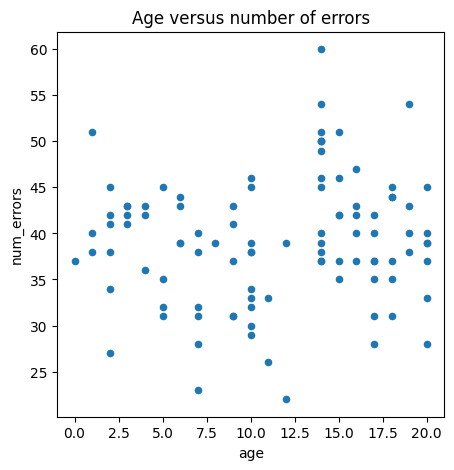

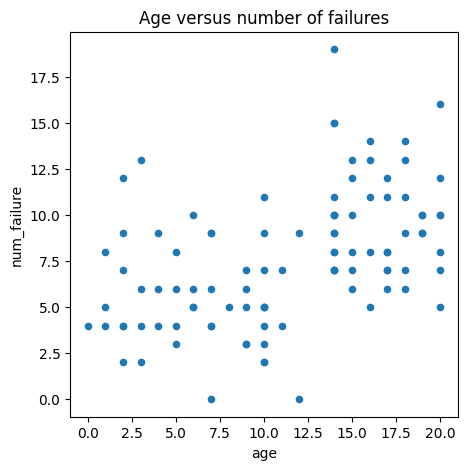

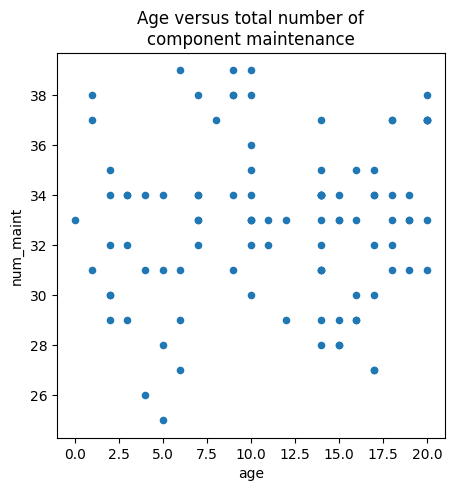

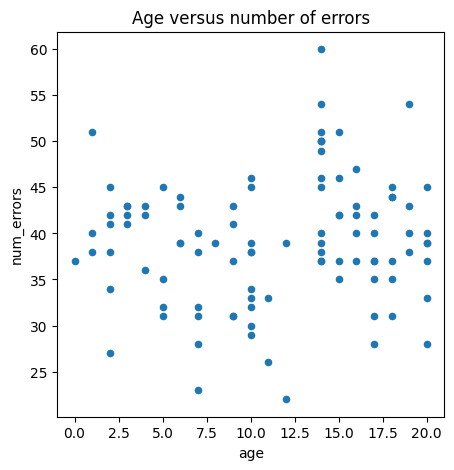

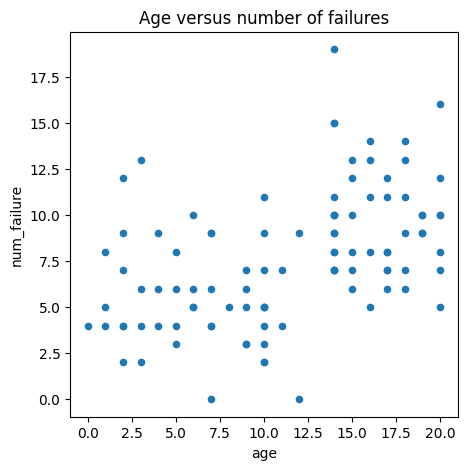

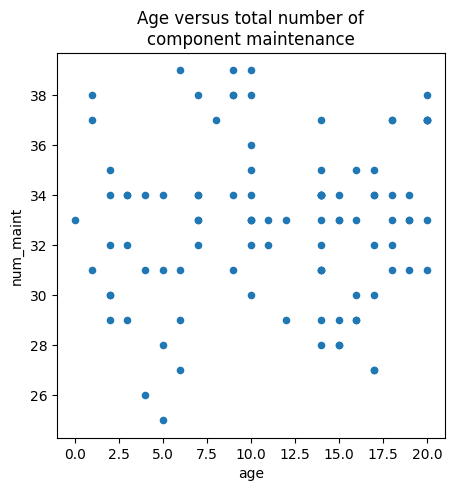

In [46]:
plot_scatter(machines_fail_data, "age", "num_errors", 
             title="Age versus number of errors")

plot_scatter(machines_fail_data, "age", "num_failure", 
             title="Age versus number of failures")

plot_scatter(machines_fail_data, "age", "num_maint", 
             title="Age versus total number of\ncomponent maintenance")
plt.show()

In [44]:
corr = machines_fail_data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/tmp/ipykernel_134383/350905018.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = machines_fail_data.corr()
/tmp/ipykernel_134383/350905018.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,machineID,age,num_errors,num_maint,num_failure
machineID,1.00,0.10,0.11,-0.08,0.10
age,0.10,1.00,0.11,0.08,0.47
num_errors,0.11,0.11,1.00,-0.03,0.54
num_maint,-0.08,0.08,-0.03,1.00,-0.04
num_failure,0.10,0.47,0.54,-0.04,1.00


In [45]:
augmented_features = labeled_features.copy()
augmented_features['month'] = augmented_features.datetime.dt.month
augmented_features['week_of_year'] = augmented_features.datetime.dt.isocalendar().week
augmented_features['hour'] = augmented_features.datetime.dt.hour

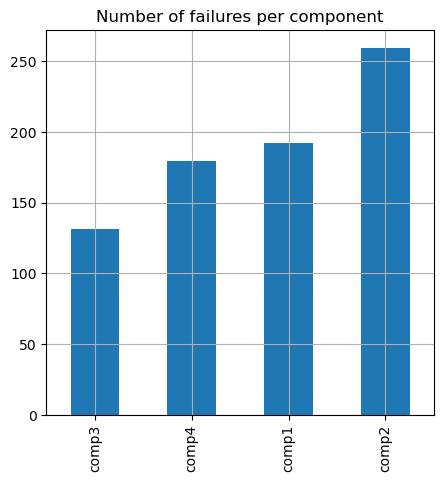

Failures per machine per component

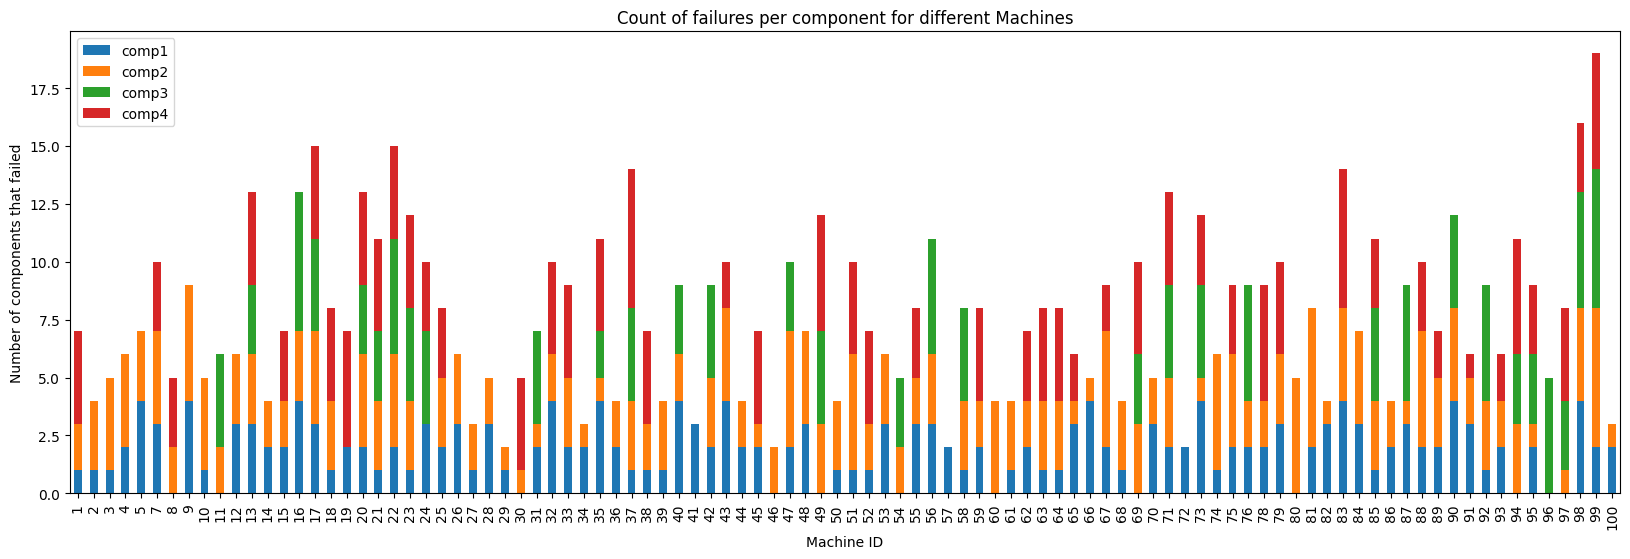

In [47]:
temp_df = failures_df.groupby(["machineID", "failure"]).size().reset_index()
temp_df.columns = ["machineID", "comp", "num_fail"]
temp_df_pivot = pd.pivot(temp_df, index="machineID", columns="comp", values="num_fail").rename_axis(None, axis=1)

temp_df_pivot.plot.bar(stacked=True, figsize=(20, 6), title="Count of failures per component for different Machines")
plt.xlabel("Machine ID")
plt.ylabel("Number of components that failed")

plt.show()

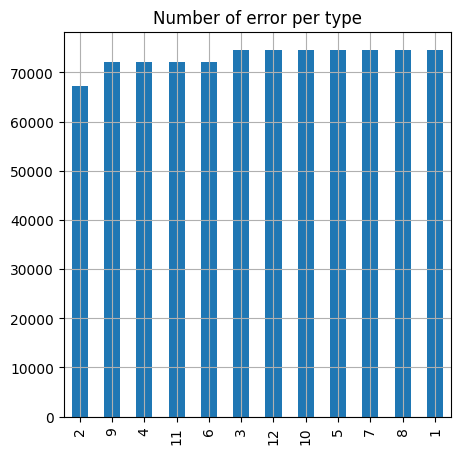

In [48]:
augmented_features['month'].value_counts(
                normalize=False, dropna=False).sort_values().plot(
                kind='bar', figsize=(5,5), grid=True,
                title='Number of error per type')
    
plt.show()

## Regression

In [ ]:
def split(data,ToRemove,target,features_to_use,perc=0.8,clean=False):
    features = [c for c in data.columns if not (c in ToRemove or c in target)]
    features = features_to_use
    if clean==True:
        return data[features],data[target]
    
    machines = pd.read_csv('../data/raw2/PdM_machines.csv')
    x_train_,x_test_,y_train_,y_test_,train_idx,test_idx = train_test_split(machines, machines.model, machines.machineID.index, test_size=0.2, stratify=machines.model, random_state=42)
    
    print(y_test_.value_counts())
    print(y_train_.value_counts())
    print(machines.model.value_counts())

    training=data[data['machineID'].isin(train_idx)]
    test=data[data['machineID'].isin(test_idx)]
    x_train=training[features]
    y_train=training[target]
    x_test=test[features]
    y_test=test[target]
    
    print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)
    
    return x_train,y_train,x_test,y_test

def preprocess(X_init,test_size,classi=False):

        X_init = X_init.to_numpy()

        y = X_init[:,-1]
        X = X_init[:,:-1]

        X_train_unsc, X_test_unsc, y_train_unsc, y_test_unsc = split(X, y, test_size=test_size, random_state=0)

        X_mean = X_train_unsc.mean(axis=0)
        X_std = X_train_unsc.std(axis=0)

        y_std = y_train_unsc.std()
        y_mean = y_train_unsc.mean()

        X_train = (X_train_unsc - X_mean)/ X_std
        X_test = (X_test_unsc - X_mean)/X_std

        y_train = (y_train_unsc- y_mean)/ y_std 
        y_test = (y_test_unsc- y_mean)/y_std        

        X_train_torch = torch.tensor(X_train).float()

        if model == SVI_model_format.poisson['name']:
            y_train_torch = torch.tensor(y_train * y_std + y_mean).int()
        else:
            y_train_torch = torch.tensor(y_train).float()
        
        if classi:
            y_train_torch = torch.tensor(y_train_unsc).float()
            y_train = y_train_unsc
            y_test = y_test_unsc
        
        X_test_torch = torch.tensor(X_test).float()

        return y, X, X_train_torch, y_train_torch,X_test_torch, X_test, y_test, X_train, y_train, y_std, y_mean

### SVI

In [ ]:
class SVI_model_format():
    '''
    defining the type of the regression
    '''
    poisson = {'name':"POISSON", 'model':poisson_model}
    heterosc = {'name':"HETEROSCEDASTIC", 'model':heteroscedastic_model}
    linear = {'name':"LINEAR", 'model':linear_model}

class SVI_regression_model():
    '''
    SVI regression: choosing the correct data, preprocess them, pyro inference and prediction
    '''
    def __init__(self, data: pd.DataFrame, component: str) -> None:
        
        self.data = data
        self.component = component

    def get_data_for_component(self) -> pd.DataFrame:
        
        '''
        returns the feautures of the dataset and the component we want to predict for
        '''
    
        cols = ['voltmean_3h', 'rotatemean_3h',
                'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
                'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
                'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
                'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
                'error3count', 'error4count', 'error5count','age',
                'model_model1', 'model_model2', 'model_model3', 'model_model4', self.component]

        return self.data[cols]
    
    def preprocess(self, X_init: pd.DataFrame, model: str) -> \
        Tuple[np.ndarray, np.ndarray,  torch.tensor,  torch.tensor, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.float64, np.float64]:

        '''
        the necessary data preprocess before procceding in pyro inference
        '''
        print(f"{model} Regression")

        X = X_init.to_numpy()

        # Keep the last column as target y
        y = X[:,-1]
        X = X[:,:-1]

        # standardize input features
        X_mean = X.mean(axis=0)
        X_std = X.std(axis=0)
        X = (X - X_mean) / X_std

        # standardize pickups
        y_mean = y.mean()
        y_std = y.std()
        y = (y - y_mean) / y_std

        train_perc = 0.80 # percentage of training data
        split_point = int(train_perc*len(y))
        perm = np.random.permutation(len(y))
        ix_train = perm[:split_point]
        ix_test = perm[split_point:]
        X_train = X[ix_train,:]
        X_test = X[ix_test,:]
        y_train = y[ix_train]
        y_test = y[ix_test]

        # Prepare data for Pyro model
        X_train_torch = torch.tensor(X_train).float()

        if model == SVI_model_format.poisson['name']:
            y_train_torch = torch.tensor(y_train * y_std + y_mean).int()
        else:
            y_train_torch = torch.tensor(y_train).float()
           
        return y, X, X_train_torch, y_train_torch, X_test, y_test, X_train, y_train, y_std, y_mean
    
    def pyro_inference(self, X_train_torch: torch.tensor, y_train_torch: torch.tensor, model: object, steps: int):
        '''
        pyro inference
        '''

        # Define guide function
        guide = AutoDiagonalNormal(model)

        # Reset parameter values
        pyro.clear_param_store()

        # Define the number of optimization steps
        n_steps = steps

        # Setup the optimizer
        adam_params = {"lr": 0.0001} # learning rate (lr) of optimizer
        optimizer = ClippedAdam(adam_params)

        # Setup the inference algorithm
        elbo = Trace_ELBO(num_particles=1)
        svi = SVI(model, guide, optimizer, loss=elbo)

        # Do gradient steps
        for step in range(n_steps):
            elbo = svi.step(X_train_torch, y_train_torch)
            if step % 100 == 0:
                print("[%d] ELBO: %.1f" % (step, elbo))

        return guide
    
    def post_process(self, guide: object, model: object, X_train_torch: torch.tensor, y_train_torch: torch.tensor, X_test: np.ndarray, y_test: np.ndarray, y_std: np.float64, y_mean: np.float64):

        if model['name'] != SVI_model_format.heterosc['name']:
            predictive = Predictive(model=model['model'], guide=guide, num_samples=1000, return_sites=("alpha", "beta", "sigma"))
            samples = predictive(X_train_torch, y_train_torch)

            alpha_samples = samples["alpha"].detach().numpy()
            beta_samples = samples["beta"].detach().numpy()

            y_hat = np.mean(np.exp(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T)), axis=1)

        else:
            predictive = Predictive(model=model['model'], guide=guide, num_samples=1000,
                        return_sites=("alpha_mu", "beta_mu", "alpha_v", "beta_v"))
            samples = predictive(X_train_torch, y_train_torch)

            alpha_samples = samples["alpha_mu"].detach().numpy()
            beta_samples = samples["beta_mu"].detach().numpy()

            y_hat = np.mean(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T), axis=1)

        # convert back to the original scale
        preds = y_hat # no need to do any conversion here because the Poisson model received untransformed y's
        y_true = y_test * y_std + y_mean

        return preds, y_true
